## Summary

This notebook summarizes the steps performed for data clearning, model selection, tunning and feature selection created in preparation to creating a production pipeline.



In [8]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import re
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import psycopg2
from sqlalchemy import create_engine, inspect
import seaborn as sns
import matplotlib.pyplot as plt

import re
import warnings
warnings.filterwarnings('ignore')
import tqdm
import random

import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
pd.set_option('max_rows', 250)
pd.set_option('display.max_colwidth', 1000)

# Ingest Data

In [25]:
#Fisrst we list the cities which from which we will scrap the data from the insideAirbnb site
#The run the get data function

list_of_cities =  [
    'asheville',
    'austin',
    'boston',
    'broward-county',
    'cambridge',
    'chicago',
    'clark-county',
    'columbus',
    'dallas',
    'denver',
    'hawaii',
    'jersey-city',
    'los-angeles',
    'nashville',
    'new-orleans',
    'new-york-city',
    'oakland',
    'pacific-grove',
    'palm-springs',
    'philadelphia',
    'portland',
    'raleigh',
    'salem',
    'san-clara-county',
    'san-diego',
    'san-francisco',
    'san-mateo-county',
    'santa-cruz-county',
    'santa-monica',
    'seattle',
    'twin-cities',
    'washington-dc'
]


GetData(url, list_of_cities, list_of_files)

Downloaded data/asheville/listings.csv.gz to data/asheville
Downloaded data/austin/listings.csv.gz to data/austin
Downloaded data/broward-county/listings.csv.gz to data/broward-county
Downloaded data/cambridge/listings.csv.gz to data/cambridge
Downloaded data/chicago/listings.csv.gz to data/chicago
Downloaded data/clark-county/listings.csv.gz to data/clark-county
Downloaded data/columbus/listings.csv.gz to data/columbus
Downloaded data/dallas/listings.csv.gz to data/dallas
Downloaded data/denver/listings.csv.gz to data/denver
Downloaded data/hawaii/listings.csv.gz to data/hawaii
Downloaded data/jersey-city/listings.csv.gz to data/jersey-city
Downloaded data/los-angeles/listings.csv.gz to data/los-angeles
Downloaded data/nashville/listings.csv.gz to data/nashville
Downloaded data/new-orleans/listings.csv.gz to data/new-orleans
Downloaded data/new-york-city/listings.csv.gz to data/new-york-city
Downloaded data/oakland/listings.csv.gz to data/oakland
Downloaded data/pacific-grove/listings

In [10]:
def GetData(url, list_of_cities, list_of_files):
    import requests
    from bs4 import BeautifulSoup
    import os
    import pickle

    ## This script gets a list of cities and file names and downloads it from the page only when the data changes
    processed_links = []

    # Check if the pickle file with lisnks exist
    if not os.path.isfile('processed_links.pkl'):
        # If the file does not exist, create an empty list and save it to the file
        with open('processed_links.pkl', 'wb') as file:
            pickle.dump(processed_links, file)
    else:
        with open('processed_links.pkl', 'rb') as pickle_file:
            processed_links = pickle.load(pickle_file)

    # Send get request
    response = requests.get(url)
    response.raise_for_status()


    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')

    # Get Page Links
    links = [a['href'] for a in soup.find_all('a', href=True) if a.text]

    # Filter only links that end with desired file names
    filtered_links =[]

    for link in links:
        # Download files if the link ends with any of the file names in your list
        if any(city.lower() in link.lower() for city in list_of_cities):
            if any(link.endswith(file_name) for file_name in list_of_files):
                filtered_links.append(link)


    # Get not seen links for download          
    new_links = [link for link in filtered_links if link not in processed_links]

    processed_links = filtered_links
    with open('processed_links.pkl', 'wb') as file:
            pickle.dump(processed_links, file)

    for city in list_of_cities:
        folder_name = 'data/'+ city
        if not os.path.exists(folder_name):
                    os.makedirs(folder_name)

        for link in new_links:
            if city.lower() in link.lower():
                response = requests.get(link)
                response.raise_for_status() 

                filename = os.path.join(folder_name, link.split('/')[-1])
                with open(filename, 'wb') as file:
                    file.write(response.content)
                print(f'Downloaded {filename} to {folder_name}')
                
    return

In [9]:
#This function ingest the data and perform basic format cleansing

def ingest_data(list_of_cities,list_of_files):


    folder_path = "data"

    df_dic = {}
    geojson_list =[]
    for city in list_of_cities:

        # List all files in the folder
        full_path = folder_path +'/'+ city 
        files = os.listdir(full_path  )
        for file in files:
            if file in list_of_files:
                df=pd.DataFrame()
                if file.endswith(('.gz')):
                    df = pd.read_csv(full_path + '/' + file , compression='gzip')
                elif file.endswith(('.geojson')):
                    with open(os.path.join(full_path, file)) as f:
                        data = json.load(f)
                        geojson_list.append((city,snapshot,file, data))
                elif file.endswith(('.csv')):
                    df = pd.read_csv(full_path + '/' + file )
                df['city'] = city
                df['file']=file

                if file.endswith(('.gz', '.csv')):
                    if file.replace(".",'_') in df_dic:
                        df_dic[file.replace(".",'_')]= pd.concat([df_dic[file.replace(".",'_')],df]) \
                                                         .drop_duplicates()
                    else: 
                        df_dic[file.replace(".",'_')]=df
                    print(full_path + '/' + file)


    # Saving it to pickle as an intermediary step

    for key in df_dic:
            # Shuffle the data
        df_dic[key] = df_dic[key].sample(frac=1).reset_index(drop=True)
        df_dic[key].to_pickle(key + ".pkl")
        print (key, 'Save as pickle')
    
    return
    


In [26]:


ingest_data(list_of_cities,list_of_files)

data/asheville/listings.csv.gz
data/austin/listings.csv.gz
data/boston/listings.csv.gz
data/broward-county/listings.csv.gz
data/cambridge/listings.csv.gz
data/chicago/listings.csv.gz
data/clark-county/listings.csv.gz
data/columbus/listings.csv.gz
data/dallas/listings.csv.gz
data/denver/listings.csv.gz
data/hawaii/listings.csv.gz
data/jersey-city/listings.csv.gz
data/los-angeles/listings.csv.gz
data/nashville/listings.csv.gz
data/new-orleans/listings.csv.gz
data/new-york-city/listings.csv.gz
data/oakland/listings.csv.gz
data/pacific-grove/listings.csv.gz
data/portland/listings.csv.gz
data/salem/listings.csv.gz
data/san-diego/listings.csv.gz
data/san-francisco/listings.csv.gz
data/san-mateo-county/listings.csv.gz
data/santa-cruz-county/listings.csv.gz
data/seattle/listings.csv.gz
data/twin-cities/listings.csv.gz
data/washington-dc/listings.csv.gz
listings_csv_gz Save as pickle


# Feature Trimming - Include only features that can be incoporated into the tool 

This is likely to yeild a lower R squared due to the fact that not all relevant features are being included.
Also removes nulls from keys features and nulls from first review which may indicate that the listing may not have had stays


In [27]:
listings_csv_gz =pd.read_pickle('listings_csv_gz.pkl')

keep_cols = [ 'neighbourhood_cleansed',
             'property_type' , 
             'room_type', 
             'accommodates',
             'bathrooms_text',
             'bedrooms',
             'beds', 
             'review_scores_value',
             'price',  
             'city']

def trim_and_encode_listings(listings_csv_gz, keep_cols ):
    # Fix pricing
    listings_csv_gz.price = listings_csv_gz.price.replace(',','',regex=True
                                                     ).replace('\$','',regex=True).astype('float')



    # Also Trim columns with no reviews to remove inactive properties
    trimmed_listings = listings_csv_gz.dropna(subset=[
                                               'first_review'], how='all', inplace=False)


    # drop rows where bathrooms text, bedrooms or beds are null
    trimmed_listings = trimmed_listings.dropna(subset=[
                                                'bathrooms_text',
                                                'bedrooms',
                                                'beds',
                                                'review_scores_value'],how='any', inplace=False)
    
    trimmed_listings = trimmed_listings[keep_cols]
    trimmed_listings = trimmed_listings[trimmed_listings.review_scores_value > 4.5]


    
    def extract_numeric_value(series):

        numeric_series = series.apply(lambda x: re.findall(r'\d+\.\d+|\d+', x))
        numeric_series = numeric_series.apply(lambda x: float(x[0]) if len(x) > 0 else 0)
        return numeric_series


    # Get integer in text:    
    trimmed_listings.bathrooms_text =  extract_numeric_value(trimmed_listings.bathrooms_text)
    
    
    
    
    
    return trimmed_listings
    

In [28]:
trimmed_listings = trim_and_encode_listings(listings_csv_gz, keep_cols )

#### Function Encode Categorical Listings

In [29]:
## Encode listings

def encoded_listings(df):
    

    def one_hot_encode(df, column_name):
        df_encoded = pd.get_dummies(df, columns=[column_name], prefix=[column_name], drop_first=True)
        return df_encoded

    # one hot encode:
    for column_name in ['room_type', 'neighbourhood_cleansed','city', 'property_type' ]:
        df = one_hot_encode(df, column_name)

    df.head().to_csv('encoded_listings.csv',index=False)

    return df

### Price Columns contains outliers. We will further trim the data to remove it but first we will run several scenarios to obtain the best cut.
Based on the analysis below the cutoffs of minimun at 30 and max at 2000 are the ones yielding the best results

<AxesSubplot:>

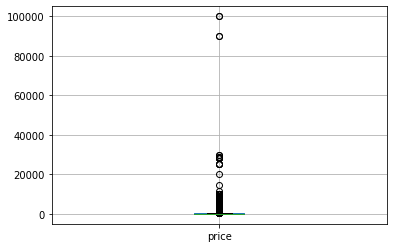

In [48]:
trimmed_listings.boxplot(column='price')

In [31]:
#Function to remove outliers and create models

def remove_outliers_and_save_model( high_cut_off, low_cut_off = 10, no_eval = True):
    selected_models = [#'Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 
                       'LightGBM']
    
    # Filtering out records outside the low and high cut-off range
    filtered_data = trimmed_listings[(trimmed_listings.price >= low_cut_off) & (trimmed_listings.price <= high_cut_off)]
    
    # Counting excluded records
    excluded = len(trimmed_listings) - len(filtered_data)
    print(excluded, 'records excluded')
    print(len(filtered_data), 'records included')
    filtered_data.to_pickle('filtered_data')
    
    if no_eval== False:
    # Perform model grid search on the filtered data
        results = model_grid_search(encoded_listings(filtered_data), selected_models=selected_models)

        results['low_cut_off'] = low_cut_off
        results['high_cut_off'] = high_cut_off
        results['excluded'] = excluded
        #results.to_pickle('results_{}_{}.pkl'.format(low_cut_off, high_cut_off))
        
        return_value= results, filtered_data
    
    else:
        return_value=  filtered_data
    
    return return_value

In [32]:
#Tunning function to select the best model and the best version of the model

def model_grid_search(df, selected_models=None, cv=5, test_size=0.2, n_estimators=[50, 100, 200]):


    # Separate features (X) and target variable (y)
    X = df.drop('price', axis=1)
    y = df['price']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Perform feature scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the regression models with their parameter grids
    regressors = {
        'Linear Regression': (LinearRegression(), {}),
        'Ridge': (Ridge(), {'alpha': [0.1, 1.0, 10.0]}),
        'Lasso': (Lasso(tol=0.001, max_iter=2000), {'alpha': [0.1, 1.0, 10.0]}),
        'ElasticNet': (ElasticNet(), {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.25, 0.5, 0.75]}),
        'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 20]}),
        'Random Forest': (RandomForestRegressor(), {'n_estimators': n_estimators}),
        'Gradient Boosting': (GradientBoostingRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
        'XGBoost': (XGBRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
        'LightGBM': (LGBMRegressor(), {'n_estimators': n_estimators, 'learning_rate': [0.01, 0.1, 1.0]}),
        'k-NN': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 10, 100]}),
        'Neural Network': (MLPRegressor(), {'hidden_layer_sizes': [(100,), (100, 100), (50, 50, 50)]})
    }

    # Train and evaluate each selected regression 
    results = {'RMSE': [], 'R-squared': [], 'Best Parameters': [], 'elapsed_time': []}

    if selected_models is None:
        selected_models = regressors.keys()

    for name in selected_models:
        regressor, param_grid = regressors[name]
        start = datetime.datetime.now()
        print('Starting ', name, ' - ', start)
        grid_search = GridSearchCV(regressor, param_grid, scoring='neg_mean_squared_error', cv=cv)
        grid_search.fit(X_train_scaled, y_train)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
        predictions = best_estimator.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        results['RMSE'].append(rmse)
        results['R-squared'].append(r2)
        results['Best Parameters'].append(best_params)
        
        end = datetime.datetime.now()
        elapsed_time = end - start
        results['elapsed_time'].append(elapsed_time)
        
        print(name, 'regression complete - ', end, 'elapsed: ', elapsed_time, '-', r2)

        # Save the best performing model
        model_filename = f"{name.lower().replace(' ', '-')}_prod_model.pkl"
        joblib.dump(best_estimator, model_filename)

    # Create table
    results_df = pd.DataFrame(results, index=selected_models)
    
    return results_df

In [33]:

for high_cut_off in [2000, 1500, 1000,700]:
    for low_cut_off in [0, 15,30, 45]:
        print('\n====== High:', high_cut_off, '- ===== Low:',low_cut_off)
        remove_outliers_and_save_model (high_cut_off, low_cut_off, no_eval =False )


====== High: 2000 - ===== Low: 0
514 records excluded
124368 records included
Starting  LightGBM  -  2023-12-11 13:56:38.928709
LightGBM regression complete -  2023-12-11 13:58:41.972533 elapsed:  0:02:03.043824 - 0.5720397250294278

====== High: 2000 - ===== Low: 15
544 records excluded
124338 records included
Starting  LightGBM  -  2023-12-11 13:58:49.262318
LightGBM regression complete -  2023-12-11 14:00:32.077373 elapsed:  0:01:42.815055 - 0.5645080400085507

====== High: 2000 - ===== Low: 30
618 records excluded
124264 records included
Starting  LightGBM  -  2023-12-11 14:00:39.095222
LightGBM regression complete -  2023-12-11 14:02:36.536646 elapsed:  0:01:57.441424 - 0.5762417704969327

====== High: 2000 - ===== Low: 45
1039 records excluded
123843 records included
Starting  LightGBM  -  2023-12-11 14:02:43.311581
LightGBM regression complete -  2023-12-11 14:04:51.863583 elapsed:  0:02:08.552002 - 0.5590398739900139

====== High: 1500 - ===== Low: 0
995 records excluded
12388

# Model Selection
We started by using LightGBM because it is a fast model that performs well but now we run all models to check if another model could perform better. Based on the results we concluded that light GBM was provides the best results between model accurancy and speed.

In [37]:
def remove_outliers_and_run_all_models( high_cut_off, low_cut_off = 10, no_eval = True):
    selected_models = ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet', 
                       'LightGBM']
    
    # Filtering out records outside the low and high cut-off range
    filtered_data = trimmed_listings[(trimmed_listings.price >= low_cut_off) & (trimmed_listings.price <= high_cut_off)]
    
    # Counting excluded records
    excluded = len(trimmed_listings) - len(filtered_data)
    print(excluded, 'records excluded')
    print(len(filtered_data), 'records included')
    filtered_data.to_pickle('filtered_data')
    
    sample_size = int(0.1 * len(filtered_data))  # Adjust the fraction as needed

    # Get a random sample of rows from the dataset
    filtered_data = filtered_data.sample(n=sample_size, random_state=42)  
    

    if no_eval== False:
    # Perform model grid search on the filtered data
        results = model_grid_search(encoded_listings(filtered_data), selected_models=selected_models)

        results['low_cut_off'] = low_cut_off
        results['high_cut_off'] = high_cut_off
        results['excluded'] = excluded
        #results.to_pickle('results_{}_{}.pkl'.format(low_cut_off, high_cut_off))
        
        return_value= results, filtered_data
    
    else:
        return_value=  filtered_data
    
    return return_value

In [38]:
remove_outliers_and_run_all_models( 2000, 30, no_eval = False)

618 records excluded
124264 records included
Starting  Linear Regression  -  2023-12-11 14:33:25.465031
Linear Regression regression complete -  2023-12-11 14:33:28.919966 elapsed:  0:00:03.454935 - -1.9305733399948026e+23
Starting  Ridge  -  2023-12-11 14:33:28.926537
Ridge regression complete -  2023-12-11 14:33:31.819893 elapsed:  0:00:02.893356 - 0.48478908876460247
Starting  Lasso  -  2023-12-11 14:33:31.826283
Lasso regression complete -  2023-12-11 14:33:35.614270 elapsed:  0:00:03.787987 - 0.48445088024371985
Starting  ElasticNet  -  2023-12-11 14:33:35.617246
ElasticNet regression complete -  2023-12-11 14:33:43.462965 elapsed:  0:00:07.845719 - 0.34924421025303787
Starting  LightGBM  -  2023-12-11 14:33:43.464829
LightGBM regression complete -  2023-12-11 14:33:52.296234 elapsed:  0:00:08.831405 - 0.491483644028182


(                           RMSE     R-squared  \
 Linear Regression  9.141292e+13 -1.930573e+23   
 Ridge              1.493334e+02  4.847891e-01   
 Lasso              1.493824e+02  4.844509e-01   
 ElasticNet         1.678315e+02  3.492442e-01   
 LightGBM           1.483600e+02  4.914836e-01   
 
                                               Best Parameters  \
 Linear Regression                                          {}   
 Ridge                                          {'alpha': 1.0}   
 Lasso                                          {'alpha': 0.1}   
 ElasticNet                   {'alpha': 0.1, 'l1_ratio': 0.75}   
 LightGBM           {'learning_rate': 0.1, 'n_estimators': 50}   
 
                             elapsed_time  low_cut_off  high_cut_off  excluded  
 Linear Regression 0 days 00:00:03.454935           30          2000       618  
 Ridge             0 days 00:00:02.893356           30          2000       618  
 Lasso             0 days 00:00:03.787987           30   

In [41]:
keep_cols = [ 'neighbourhood_cleansed',
             'property_type' , 
             'room_type', 
             'accommodates',
             'bathrooms_text',
             'bedrooms',
             'beds', 
             'review_scores_value',
             'price',  
             'city']


trimmed_listings = trim_and_encode_listings(listings_csv_gz, keep_cols )
remove_outliers_and_save_model (high_cut_off, low_cut_off, no_eval =False )

5847 records excluded
119035 records included
Starting  LightGBM  -  2023-12-11 14:41:06.050316
LightGBM regression complete -  2023-12-11 14:43:01.291712 elapsed:  0:01:55.241396 - 0.5269689136955071


(               RMSE  R-squared                              Best Parameters  \
 LightGBM  87.643699   0.526969  {'learning_rate': 0.1, 'n_estimators': 200}   
 
                    elapsed_time  low_cut_off  high_cut_off  excluded  
 LightGBM 0 days 00:01:55.241396           45           700      5847  ,
        neighbourhood_cleansed              property_type        room_type  \
 0                       78734               Entire villa  Entire home/apt   
 2                     Midtown                Entire home  Entire home/apt   
 3        Unincorporated Areas                Entire home  Entire home/apt   
 6        Unincorporated Areas  Entire serviced apartment  Entire home/apt   
 8                 District 19          Entire guesthouse  Entire home/apt   
 ...                       ...                        ...              ...   
 265543        Fort Lauderdale           Entire townhouse  Entire home/apt   
 265547               Highland                Entire home  Entire hom

## Feature Selection 
Given that we started by selecting a very small number of features we will limit feature slection to test the effect of removing a few numerical features from the list.
Based on the findings below we could remove beds from the list without having much impact to model performance.


In [42]:
keep_cols = [ 'neighbourhood_cleansed',
             'property_type' , 
             'room_type', 
             'accommodates',
             'bathrooms_text',
             'bedrooms',
             #'beds', 
             'review_scores_value',
             'price',  
             'city']


trimmed_listings = trim_and_encode_listings(listings_csv_gz, keep_cols )
remove_outliers_and_save_model (high_cut_off, low_cut_off, no_eval =False )

5847 records excluded
119035 records included
Starting  LightGBM  -  2023-12-11 14:43:13.910915
LightGBM regression complete -  2023-12-11 14:45:07.560709 elapsed:  0:01:53.649794 - 0.5258014478773292


(               RMSE  R-squared                              Best Parameters  \
 LightGBM  87.751787   0.525801  {'learning_rate': 0.1, 'n_estimators': 200}   
 
                    elapsed_time  low_cut_off  high_cut_off  excluded  
 LightGBM 0 days 00:01:53.649794           45           700      5847  ,
        neighbourhood_cleansed              property_type        room_type  \
 0                       78734               Entire villa  Entire home/apt   
 2                     Midtown                Entire home  Entire home/apt   
 3        Unincorporated Areas                Entire home  Entire home/apt   
 6        Unincorporated Areas  Entire serviced apartment  Entire home/apt   
 8                 District 19          Entire guesthouse  Entire home/apt   
 ...                       ...                        ...              ...   
 265543        Fort Lauderdale           Entire townhouse  Entire home/apt   
 265547               Highland                Entire home  Entire hom

In [44]:
keep_cols = [ 'neighbourhood_cleansed',
             'property_type' , 
             'room_type', 
             'accommodates',
             'bathrooms_text',
             #'bedrooms',
             'beds', 
             'review_scores_value',
             'price',  
             'city']

trimmed_listings = trim_and_encode_listings(listings_csv_gz, keep_cols )
remove_outliers_and_save_model (high_cut_off, low_cut_off, no_eval =False )

5847 records excluded
119035 records included
Starting  LightGBM  -  2023-12-11 14:45:21.448205
LightGBM regression complete -  2023-12-11 14:47:05.446793 elapsed:  0:01:43.998588 - 0.5184311500096754


(               RMSE  R-squared                              Best Parameters  \
 LightGBM  88.431105   0.518431  {'learning_rate': 0.1, 'n_estimators': 200}   
 
                    elapsed_time  low_cut_off  high_cut_off  excluded  
 LightGBM 0 days 00:01:43.998588           45           700      5847  ,
        neighbourhood_cleansed              property_type        room_type  \
 0                       78734               Entire villa  Entire home/apt   
 2                     Midtown                Entire home  Entire home/apt   
 3        Unincorporated Areas                Entire home  Entire home/apt   
 6        Unincorporated Areas  Entire serviced apartment  Entire home/apt   
 8                 District 19          Entire guesthouse  Entire home/apt   
 ...                       ...                        ...              ...   
 265543        Fort Lauderdale           Entire townhouse  Entire home/apt   
 265547               Highland                Entire home  Entire hom

In [45]:
keep_cols = [ 'neighbourhood_cleansed',
             'property_type' , 
             'room_type', 
             #'accommodates',
             'bathrooms_text',
             'bedrooms',
             'beds', 
             'review_scores_value',
             'price',  
             'city']

trimmed_listings = trim_and_encode_listings(listings_csv_gz, keep_cols )
remove_outliers_and_save_model (high_cut_off, low_cut_off, no_eval =False )

5847 records excluded
119035 records included
Starting  LightGBM  -  2023-12-11 14:47:19.205779
LightGBM regression complete -  2023-12-11 14:49:11.892996 elapsed:  0:01:52.687217 - 0.5195208931312386


(               RMSE  R-squared                              Best Parameters  \
 LightGBM  88.330993   0.519521  {'learning_rate': 0.1, 'n_estimators': 200}   
 
                    elapsed_time  low_cut_off  high_cut_off  excluded  
 LightGBM 0 days 00:01:52.687217           45           700      5847  ,
        neighbourhood_cleansed              property_type        room_type  \
 0                       78734               Entire villa  Entire home/apt   
 2                     Midtown                Entire home  Entire home/apt   
 3        Unincorporated Areas                Entire home  Entire home/apt   
 6        Unincorporated Areas  Entire serviced apartment  Entire home/apt   
 8                 District 19          Entire guesthouse  Entire home/apt   
 ...                       ...                        ...              ...   
 265543        Fort Lauderdale           Entire townhouse  Entire home/apt   
 265547               Highland                Entire home  Entire hom